In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense  ,Dropout
from keras.optimizers import Adam
from sklearn.metrics import r2_score
from tqdm import tqdm
from lazypredict.Supervised import LazyRegressor


# Prepare

In [223]:
def _load_data():
    train=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Training set 2011-2015')
    train.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    train=train.drop(list(train[train.isna().any(axis=1)].index),axis=0)

    test=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Testing set 2016-2019 ')
    test.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    test=test.drop(list(test[test.isna().any(axis=1)].index),axis=0)

    print(train.shape,test.shape)
    return train , test

def _prepare_data(data):
    X_train=data.drop(['dissolved_oxygen'],axis=1)
    y_train=data.dissolved_oxygen
    return X_train , y_train

def _scale_data(X_train,y_train):
    X_scaler=StandardScaler()
    X_train_scaled=X_scaler.fit_transform(X_train)
    y_scaler=StandardScaler()
    y_train_scaled=y_scaler.fit_transform(np.array(y_train).reshape(-1,1))
    print(X_train_scaled.shape, y_train_scaled.shape)
    return X_train_scaled,y_train_scaled , X_scaler , y_scaler

def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

# Model


In [ ]:
model = Sequential()
model.add(Dense(10, input_shape=(X_train[0].shape[0],), kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, y_train,epochs=10,batch_size=8)

KerasRegressor(model=model, epochs=100, batch_size=5, verbose=0).fit(X_train, y_train)


we have some missing values here

In [ ]:
nonul_train=train.drop(list(train[train.isna().any(axis=1)].index),axis=0)
X_train,y_train=_prepare_data(nonul_train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)



In [ ]:
nonul_test=test.drop(list(test[test.isna().any(axis=1)].index),axis=0)
X_test,y_test=_prepare_data(nonul_test)

X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))


let's create the model and compile it

In [ ]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(X_train[0].shape[0], input_shape=(X_train[0].shape[0],), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2


In [ ]:
history , r2=_compile_model(X_train,y_train,X_test,y_test,80,32)

batch size itrator

In [ ]:
r2_all=[]
for item in tqdm([8,16,32,64,128,256,512]):
    history , r2=_compile_model(X_train,y_train,X_test,y_test,80,item)
    r2_all.append(r2)

In [ ]:
plt.bar(range(7),r2_all)
plt.xticks(range(7),[8,16,32,64,128,256,512])
plt.xlabel('batch_size')
plt.ylabel('R_squared')
plt.show()

epochs

In [ ]:
# r2_all=[]
for item in tqdm(range(150,200,10)):
    history , r2=_compile_model(X_train,y_train,X_test,y_test,item,8)
    r2_all.append(r2)

In [ ]:
plt.bar(range(len(r2_all)),r2_all)
plt.xticks(range(len(r2_all)),range(10,200,10))
plt.xlabel('epochs')
plt.ylabel('R_squared')
plt.show()

# The best we have

In [ ]:
x=X_test[:100,:]
y=y_test[:100,:]

In [ ]:
history , r2=_compile_model(X_train,y_train,x,y,100,8)

In [ ]:
r2

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

# ANN Model
it gives us r2=0.36

In [224]:
train , test =_load_data()

(605, 11) (461, 11)


In [227]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
# X_test_scaler=StandardScaler()
# y_test_scaler=StandardScaler()
# X_test=X_test_scaler.fit_transform(X_test)
# y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

(605, 10) (605, 1)


Epoch 1/70
76/76 [==============================] - 2s 13ms/step - loss: 1.0000 - val_loss: 0.7754
Epoch 2/70
76/76 [==============================] - 1s 8ms/step - loss: 1.0000 - val_loss: 0.7754
Epoch 3/70
76/76 [==============================] - 1s 7ms/step - loss: 1.0000 - val_loss: 0.7753
Epoch 4/70
76/76 [==============================] - 0s 6ms/step - loss: 0.9996 - val_loss: 0.7747
Epoch 5/70
76/76 [==============================] - 0s 6ms/step - loss: 0.9984 - val_loss: 0.7725
Epoch 6/70
76/76 [==============================] - 0s 6ms/step - loss: 0.9946 - val_loss: 0.7670
Epoch 7/70
76/76 [==============================] - 0s 5ms/step - loss: 0.9857 - val_loss: 0.7537
Epoch 8/70
76/76 [==============================] - 0s 6ms/step - loss: 0.9677 - val_loss: 0.7302
Epoch 9/70
76/76 [==============================] - 0s 6ms/step - loss: 0.9396 - val_loss: 0.6989
Epoch 10/70
76/76 [==============================] - 0s 7ms/step - loss: 0.9089 - val_loss: 0.6662
Epoch 11/70
76/76 

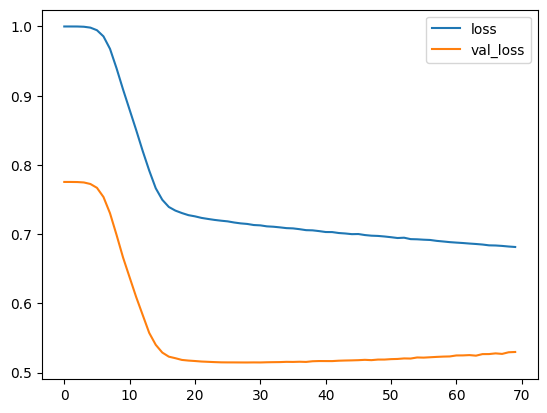

0.31630193003044427

In [228]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(35, input_shape=(X_train[0].shape[0],),kernel_initializer='RandomUniform', activation='relu'))
    model.add(Dense(25,kernel_initializer='RandomUniform', activation='relu'))
    model.add(Dense(12,kernel_initializer='RandomUniform', activation='relu'))
    model.add(Dense(6,kernel_initializer='RandomUniform', activation='relu'))
    model.add(Dense(1,kernel_initializer='RandomUniform',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred
history , r2 , y_pred=_compile_model(X_train,y_train,X_test,y_test,70,8)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
r2

# Data Augmentation

In [ ]:
train,test=_load_data()

fake=pd.DataFrame([[1,2,3,4,5,6,7,8,9,10,11]],columns=train.columns,index=range(2000))
fake.columns
for item in fake.columns:
    fake[item]=np.random.random(2000)
fake['fake']=np.ones(len(fake))
fake

In [ ]:
train['fake']=np.zeros(len(train))
df=pd.concat([fake,train],axis=0)
df.reset_index(drop=True,inplace=True)
df

In [ ]:
from imblearn.over_sampling import SMOTE
X=df.drop(['fake'],axis=1)
y=df.fake
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X['fake']=y
X

In [ ]:
plt.bar(1,len(df[df.fake==1]))
plt.bar(0,len(df[df.fake==0]))
plt.show()
plt.bar(1,len(X[X.fake==1]))
plt.bar(0,len(X[X.fake==0]))
plt.show()

In [ ]:
train=X[X.fake==0]
train.drop(['fake'],axis=1,inplace=True)
train

In [ ]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
# X_test_scaler=StandardScaler()
# y_test_scaler=StandardScaler()

# X_test=X_test_scaler.fit_transform(X_test)
# y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

In [ ]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train[0].shape[0],),kernel_initializer='normal', activation='relu'))
    model.add(Dense(15,kernel_initializer='normal', activation='relu'))
    model.add(Dense(5,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1,kernel_initializer='normal',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred

history , r2 , y_pred=_compile_model(X_train,y_train,X_test,y_test,100,8)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
print('R_squared is:',r2)

# Hybrid model

In [124]:
train , test =_load_data()

(605, 11) (461, 11)


In [171]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
X_test_scaler=StandardScaler()
y_test_scaler=StandardScaler()
X_test=X_test_scaler.fit_transform(X_test)
y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
# X_test=X_scaler.transform(X_test)
# y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

(605, 10) (605, 1)


In [172]:
def _create_NN_features():
    model = Sequential()


    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))
    model.fit(X_train, y_train,epochs=40,batch_size=8,validation_split=0.2)
    nnfeatures=model.predict(X_train)
    return nnfeatures , model

In [173]:
df_train , model =_create_NN_features()
df_test=model.predict(X_test)

# df_train=X_scaler.transform(df_train)
# df_test=X_scaler.transform(df_test)

# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = reg.fit(df_train, df_test, y_train, y_test)

Epoch 1/40
61/61 [==============================] - 1s 6ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 2/40
61/61 [==============================] - 0s 3ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 3/40
61/61 [==============================] - 0s 4ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 4/40
61/61 [==============================] - 0s 3ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 5/40
61/61 [==============================] - 0s 2ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 6/40
61/61 [==============================] - 0s 4ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 7/40
61/61 [==============================] - 0s 3ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 8/40
61/61 [==============================] - 0s 3ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 9/40
61/61 [==============================] - 0s 4ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 10/40
61/61 [==============================] - 0s 3ms/step - loss: 2.1556 - val_loss: 1.0866
Epoch 11/40
61/61 [

In [175]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()  #using linear kernel for SVM regressor 
regressor.fit(df_train, y_train)  
y_pred = regressor.predict(df_test)
r2_score(y_test,y_pred)

-1.3065837041798538

# Data Exploring

In [205]:
train , test=_load_data()

(605, 11) (461, 11)


In [97]:
#create a function to find outliers using IQR

def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

# Machine Learning

In [236]:
train , test=_load_data()

(605, 11) (461, 11)


In [237]:
X_train,y_train=_prepare_data(train)
X_train,y_train , X_scaler , y_scaler=_scale_data(X_train,y_train)

X_test,y_test=_prepare_data(test)
# to set a new scaler
# X_test_scaler=StandardScaler()
# y_test_scaler=StandardScaler()
# X_test=X_test_scaler.fit_transform(X_test)
# y_test=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))

#to scale by the train scaler
X_test=X_scaler.transform(X_test)
y_test=y_scaler.transform(np.array(y_test).reshape(-1,1))

(605, 10) (605, 1)


In [238]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()  #using linear kernel for SVM regressor 
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)
r2_score(y_test,y_pred)

-5.457210958601155

In [239]:
reg=LazyRegressor()
models=reg.fit(X_train, X_test, y_train, y_test)
models[0]

100%|██████████| 42/42 [00:15<00:00,  2.72it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR,0.35,0.36,0.70,0.04
NuSVR,0.34,0.36,0.70,0.10
HuberRegressor,0.34,0.35,0.71,0.02
LinearSVR,0.33,0.34,0.71,0.02
RANSACRegressor,0.24,0.26,0.76,0.20
OrthogonalMatchingPursuit,0.23,0.25,0.76,0.02
TweedieRegressor,0.22,0.24,0.77,0.01
ElasticNetCV,0.22,0.23,0.77,0.10
LassoCV,0.21,0.23,0.77,0.09
